<a href="https://colab.research.google.com/github/Risskr/Stock-App/blob/Simplified/StocksApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up**


In [5]:
# #refesh python script
# get_ipython().kernel.do_shutdown(restart=True)

# #Check GPUs
# !nvidia-smi

#load cudf to use GPUs for analysis
#%load_ext cudf.pandas

# import pandas
import pandas as pd
import datetime
import pickle
import numpy as np
from tqdm.notebook import tqdm

#!pip install tqdm==4.66.1

#function for importing dataframes from MyDrive
def import_variable(file_name):
  load_path = f"/content/drive/MyDrive/Colab Notebooks/{file_name}"

  try:
      variable = pd.read_parquet(load_path)

      print(f"Successfully loaded data from {load_path}")

  except FileNotFoundError:
      print(f"Error: The file was not found at {load_path}")
  except Exception as e:
      print(f"An error occurred while loading the file: {e}")
  return variable

# #run this funciton with this line
# x = import_variable("testing2_2025-05-22 19:07:29.595379.parquet")

# Correlation Code

## Function: Download Raw Stock Data to My Drive

In [ ]:
# Run this if I need to download historical data and save it to MyDrive
def DownloadStockData():
  #Download the stock data
  !if [ ! -f "usa_stocks_30m.parquet" ]; then curl https://storage.googleapis.com/rapidsai/colab-data/usa_stocks_30m.parquet -o usa_stocks_30m.parquet; else echo "usa_stocks_30m.parquet found"; fi

  #move the stock data to my Drive
  !mv usa_stocks_30m.parquet "/content/drive/MyDrive/Colab Notebooks"
# DownloadStockData()

# Run this if I have already downloaded the hisotrical data and need to import
# Historical data from MyDrive
def ImportStockData():
  # Import the stock data from My Drive
  # Define nasdaq_stocks as the stock data
  # Specify the full path to the file in your Google Drive
  nasdaq_stocks = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/usa_stocks_30m.parquet")
  return nasdaq_stocks
nasdaq_stocks = ImportStockData()


# Manipulate the historical data for correlation function
def ManipulateStockData(nasdaq_stocks):
  #add year, month, and day columns
  #df[["year", "week", "day"]] = df.datetime.dt.isocalendar()
  nasdaq_stocks["year"] = nasdaq_stocks.datetime.dt.year
  nasdaq_stocks["month"] = nasdaq_stocks.datetime.dt.month
  nasdaq_stocks["day"] = nasdaq_stocks.datetime.dt.day

  # #Filter the DataFrame based on the 'year' column
  # stock_TimeFiltered = nasdaq_stocks.loc[nasdaq_stocks['year'] >= 2023]

  #stock_TimeFiltered.info()
  #stock_TimeFiltered.head()

  #aggregate data by ticker, month, day, closing cost.
  stock_TimeFiltered_aggregated_close = nasdaq_stocks.groupby(["ticker", "year", "month", "day"]).agg({"close": "last"})

  #stock_TimeFiltered_aggregated_close.info()
  #stock_TimeFiltered_aggregated_close.head()
  return stock_TimeFiltered_aggregated_close

stock_TimeFiltered_aggregated_close = ManipulateStockData(nasdaq_stocks)

In [ ]:
# prompt: I want to filter stock_TimeFiltered_aggregated_close To only show data for AAPL

aapl_data = stock_TimeFiltered_aggregated_close.loc['AAPL']

In [ ]:
aapl_data.info()
print('--------')
print(aapl_data.head(1))
print('--------')
print(aapl_data.tail(1))

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6639 entries, (np.int32(1998), np.int32(1), np.int32(2)) to (np.int32(2024), np.int32(3), np.int32(13))
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   6639 non-null   float64
dtypes: float64(1)
memory usage: 71.7 KB
--------
                close
year month day       
1998 1     2     0.14
--------
                 close
year month day        
2024 3     13   171.12


In [ ]:
  # Convert end_date to datetime object
  end_date = '2023-12-31'
  range_months = 6

   # Convert end_date to datetime object
  end_datetime = pd.to_datetime(end_date)

  # Calculate the start date for the 6-month period
  start_datetime = end_datetime - pd.DateOffset(months = range_months)

    # Filter the DataFrame for the specified date range
  # We need to create a datetime column from the index to filter
  aapl_data['datetime'] = pd.to_datetime(aapl_data.index.get_level_values('year').astype(str) + '-' +
                                   aapl_data.index.get_level_values('month').astype(str) + '-' +
                                   aapl_data.index.get_level_values('day').astype(str))
  filtered_df = aapl_data[(aapl_data['datetime'] >= start_datetime) & (aapl_data['datetime'] <= end_datetime)]
  filtered_df = filtered_df.drop(columns=['datetime']) # Drop the temporary datetime column

In [ ]:
print(f'The end date is {end_datetime}')
print(f'The end date is {start_datetime}')
print('--------')
filtered_df.info()
print('--------')
print(filtered_df.head(1))
print('--------')
print(filtered_df.tail(1))

The end date is 2023-12-31 00:00:00
The end date is 2023-06-30 00:00:00
--------
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135 entries, (np.int32(2023), np.int32(6), np.int32(30)) to (np.int32(2023), np.int32(12), np.int32(30))
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   135 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB
--------
                close
year month day       
2023 6     30   193.8
--------
                close
year month day       
2023 12    30   192.5


## Function: Correlation Coeficient for entire stock data set

In [ ]:
def calculate_lagged_correlation(df, end_date, lag_days=1, range_months=6):
  # import pandas as pd
  # import numpy as np
  # from tqdm.notebook import tqdm # Import tqdm
  """
  Calculates the pairwise Pearson correlation coefficient between all stocks
  in a DataFrame for a specified 6-month period with a given lag.

  Args:
    df: DataFrame with a MultiIndex (ticker, year, month, day) and 'close' column.
    end_date: The end date (inclusive) of the 6-month period as a string 'YYYY-MM-DD'.
    lag_days: The number of days to lag the second stock's data.

  Returns:
    A pandas DataFrame containing the pairwise correlation coefficients.
  """
  # Convert end_date to datetime object
  end_datetime = pd.to_datetime(end_date)

  # Calculate the start date for the 6-month period
  start_datetime = end_datetime - pd.DateOffset(months = range_months)

  # Filter the DataFrame for the specified date range
  # We need to create a datetime column from the index to filter
  df['datetime'] = pd.to_datetime(df.index.get_level_values('year').astype(str) + '-' +
                                   df.index.get_level_values('month').astype(str) + '-' +
                                   df.index.get_level_values('day').astype(str))
  filtered_df = df[(df['datetime'] >= start_datetime) & (df['datetime'] <= end_datetime)]
  filtered_df = filtered_df.drop(columns=['datetime']) # Drop the temporary datetime column


  # Get unique tickers in the filtered data
  tickers = filtered_df.index.get_level_values('ticker').unique()

  # Create an empty DataFrame to store correlation results
  correlation_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

  # Iterate through all pairs of tickers with a progress bar
  for ticker_a in tqdm(tickers, desc="Calculating correlations"): # Add tqdm here

    # Extract data for each ticker
    stock_a_data = filtered_df.loc[ticker_a, 'close']

    for ticker_b in tickers:
      if ticker_a != ticker_b:
        # Extract data for each ticker
        stock_b_data = filtered_df.loc[ticker_b, 'close']

        # Align the dataframes based on the date index
        aligned_data = pd.merge(stock_a_data.reset_index(), stock_b_data.reset_index(),
                                on=['year', 'month', 'day'], how='inner', suffixes=('_A', '_B'))
        aligned_data['datetime'] = pd.to_datetime(aligned_data['year'].astype(str) + '-' +
                                                  aligned_data['month'].astype(str) + '-' +
                                                  aligned_data['day'].astype(str))
        aligned_data = aligned_data.set_index('datetime').sort_index()

        # Apply the lag to stock_b_data
        lagged_stock_b_data = aligned_data['close_B'].shift(lag_days)

        # #Calculate correlation, dropping NaN values
        # correlation = aligned_data['close_A'].corr(lagged_stock_b_data)

        correlation = aligned_data['close_A'].corr(lagged_stock_b_data, method='spearman', min_periods=100)

        # Store the correlation in the matrix
        correlation_matrix.loc[ticker_a, ticker_b] = correlation

  return correlation_matrix

# enter end date and run correlation function on entire stock data. This will take a couple of hours
end_date = '2023-12-31'
spearman_lagged_correlations = calculate_lagged_correlation(stock_TimeFiltered_aggregated_close, end_date, lag_days=1)

Calculating correlations:   0%|          | 0/510 [00:00<?, ?it/s]

## Function: Export variables to My Drive

In [ ]:
# Export a panda dataframe to MyDrive
def export_variable(variable_name, file_name):

  now = datetime.datetime.now()

  save_path = f"/content/drive/MyDrive/Colab Notebooks/{file_name}_{now}.parquet"

  try:
      variable_name.to_parquet(save_path)
      print(f"Successfully saved the variable to {save_path}")
  except Exception as e:
      print(f"An error occurred while saving the file: {e}")
  return

export_variable(spearman_lagged_correlations, "spearman_lagged_correlations")

Successfully saved the variable to /content/drive/MyDrive/Colab Notebooks/spearman_lagged_correlations_2025-06-03 18:13:09.551585.parquet


# Import Correlated Data from MyDrive

In [6]:
# #import correlation data from entire stock data that I saved off earlier on MyDrive
#pearson_sixMonth_correlation_data = import_variable("6month_correlation_data.parquet")
spearman_sixMonth_correlation_data = import_variable("spearman_lagged_correlations_2025-06-03 18:13:09.551585.parquet")





Successfully loaded data from /content/drive/MyDrive/Colab Notebooks/spearman_lagged_correlations_2025-06-03 18:13:09.551585.parquet


In [ ]:
#spearman_sixMonth_correlation_data = spearman_lagged_correlations
spearman_sixMonth_correlation_data.head()

# Process correlated Data

In [7]:
def process_stock_correlations(correlation_df, min_nodes, max_nodes, threshold_percent):
  """
  Processes a DataFrame of stock correlation data by grouping, filtering for
  top correlations, and normalizing values to create 'Orbital Radius' and
  'Planet Radius' columns.

  Args:
    correlation_df: A pandas DataFrame where both index and columns are tickers
                    representing pairwise correlation coefficients.

  Returns:
    A pandas DataFrame with processed correlation data including 'source',
    'target', 'correlation', 'coefficient_of_determination', 'Orbital Radius',
    and 'Planet Radius' columns.
  """
  # Rename the index before stacking to avoid the naming conflict
  correlation_df = correlation_df.rename_axis('ticker_a', axis=0)

  # Use stack to unpivot the correlation matrix into a long format
  # This is more efficient than iterating through index and columns
  grouped_correlation_data = correlation_df.stack().reset_index()

  # Rename the columns appropriately after resetting index
  # The columns after stacking and resetting index will be 'level_0', 'level_1', and 0 by default
  grouped_correlation_data.columns = ['ticker_a', 'ticker_b', 'correlation']


  # Drop self-correlations
  grouped_correlation_data = grouped_correlation_data[grouped_correlation_data['ticker_a'] != grouped_correlation_data['ticker_b']].copy()

  # Calculate the coefficient of determination
  grouped_correlation_data['coefficient_of_determination'] = grouped_correlation_data['correlation']**2

  # Filter for only the top correlations
  # Calculate absolute correlation and group by ticker_a
  grouped_correlation_data['abs_correlation'] = grouped_correlation_data['correlation'].abs()


  # Use a list comprehension to efficiently process each group
  filtered_data_list = []
  for ticker_a, group_df in grouped_correlation_data.groupby('ticker_a'):
      max_abs_correlation = group_df['abs_correlation'].max()
      threshold = max_abs_correlation * threshold_percent

      filtered_group_df_threshold = group_df[group_df['abs_correlation'] >= threshold].copy()

      if len(filtered_group_df_threshold) < min_nodes:
          filtered_group_df = group_df.sort_values(by='abs_correlation', ascending=False).head(min_nodes).copy()
      elif len(filtered_group_df_threshold) > max_nodes:
          filtered_group_df = filtered_group_df_threshold.sort_values(by='abs_correlation', ascending=False).head(max_nodes).copy()
      else:
          filtered_group_df = filtered_group_df_threshold

      filtered_data_list.append(filtered_group_df)


  most_correlated_stocks = pd.concat(filtered_data_list)

  # # Remove the temporary 'abs_correlation' column
  # most_correlated_stocks = most_correlated_stocks.drop(columns=['abs_correlation'])

  # Normalize values for 'Orbital Radius' and 'Planet Radius'
  # Calculate min and max for normalization efficiently using groupby
  min_max_correlations = most_correlated_stocks.groupby('ticker_a')['abs_correlation'].agg(['min', 'max'])
  min_max_coefficient = most_correlated_stocks.groupby('ticker_a')['coefficient_of_determination'].agg(['min', 'max'])

  # Use apply with vectorized operations where possible
  def normalize_row(row, min_max_corr_df, min_max_coeff_df):
      ticker_a = row['ticker_a']
      correlation = row['abs_correlation']
      coefficient = row['coefficient_of_determination']

      min_corr, max_corr = min_max_corr_df.loc[ticker_a, ['min', 'max']]
      min_coeff, max_coeff = min_max_coeff_df.loc[ticker_a, ['min', 'max']]

      # Avoid division by zero if all values for a ticker are the same
      orbital_radius = 0.0 if max_corr == min_corr else 1 - (correlation - min_corr) / (max_corr - min_corr)
      planet_radius = 0.0 if max_coeff == min_coeff else (coefficient - min_coeff) / (max_coeff - min_coeff)


      return pd.Series([orbital_radius, planet_radius], index=['Orbital Radius', 'Planet Radius'])

  # Apply the normalization function
  normalized_values = most_correlated_stocks.apply(
      normalize_row,
      axis=1,
      args=(min_max_correlations, min_max_coefficient)
  )

  most_correlated_stocks[['Orbital Radius', 'Planet Radius']] = normalized_values

  # Remove the temporary 'abs_correlation' column
  most_correlated_stocks = most_correlated_stocks.drop(columns=['abs_correlation'])

  # Reset index and rename columns to the desired long format
  most_correlated_stocks_long = most_correlated_stocks.reset_index(drop=True)
  most_correlated_stocks_long = most_correlated_stocks_long.rename(columns={'ticker_a': 'source', 'ticker_b': 'target'})

  return most_correlated_stocks_long

# Example usage with the sixMonth_correlation_data
min_nodes = 5
max_nodes = 10
threshold_percent = 0.95
processed_data = process_stock_correlations(spearman_sixMonth_correlation_data, min_nodes, max_nodes, threshold_percent)
display(processed_data.head())



,source,target,correlation,coefficient_of_determination,Orbital Radius,Planet Radius
0,A,NTRS,0.926960,0.859254,0.000000,1.000000
1,A,BA,0.922795,0.851550,0.153496,0.844574
2,A,BAC,0.917391,0.841606,0.352670,0.643939
3,A,RCL,0.915201,0.837593,0.433396,0.562957
4,A,HBAN,0.915059,0.837333,0.438623,0.557720


In [ ]:
sample_processed_data = processed_data[processed_data['source'] == 'AAPL']
display(sample_processed_data)

# Create Network Diagram

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np # Added numpy for np.pi and np.cos/sin
import random # Added random for shuffling node positions

def plot_ticker_network_visual(correlated_data, source_ticker):
    """
    Plots a network graph for a specific ticker and its most correlated partners.
    The source_ticker node is yellow and larger, with its label black, bold, and centered.
    Orbiting nodes are deep blue, with their labels bold and white, centered on the node.
    Orbiting nodes have their correlation percentage displayed closer underneath them,
    colored green for positive and red for negative.
    Edges (lines) between nodes are not drawn.
    Nodes are randomly but evenly spaced around the central node.
    The overall plot size is reduced.

    Args:
      correlated_data: DataFrame with columns 'source', 'target', 'correlation',
                       'Orbital Radius', 'Planet Radius'.
      source_ticker: The ticker for which to generate the network graph.
    """
    # Filter the data to include only connections where the source ticker is the source
    # Using .copy() to avoid SettingWithCopyWarning
    ticker_connections = correlated_data[correlated_data['source'] == source_ticker].copy()

    # Handle cases where there are no connections found after filtering
    if ticker_connections.empty:
        print(f"No connections found for ticker {source_ticker} as the source within the provided data.")
        return

    # Create a graph.
    G = nx.from_pandas_edgelist(ticker_connections,
                                'source', 'target',
                                ['correlation', 'Orbital Radius', 'Planet Radius'])

    # Ensure the source_ticker is actually in the graph after creation
    if source_ticker not in G:
        G.add_node(source_ticker)


    # Customize graph visualization
    # Reduce overall plot size
    plt.figure(figsize=(10, 8)) # Reduced from (12, 10)

    fig = plt.gcf()  # Get the current figure
    ax = plt.gca()   # Get the current axes

    # --- SET BACKGROUND TO BLACK ---
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')  # The area where the network is drawn

    # --- Positioning based on 'Orbital Radius' ---
    pos = {}
    pos[source_ticker] = (0, 0) # Center the source_ticker

    actual_target_connections = ticker_connections[ticker_connections['target'] != source_ticker]
    num_connections = len(actual_target_connections)

    if num_connections > 0:
        angles = [i * (2 * np.pi / num_connections) for i in range(num_connections)]
        random.shuffle(angles)
        target_nodes_for_positioning = list(actual_target_connections['target'])

        for i, target_node_name in enumerate(target_nodes_for_positioning):
            row = actual_target_connections[actual_target_connections['target'] == target_node_name].iloc[0]
            orbital_radius = row['Orbital Radius']
            min_distance = 0.3
            current_orbital_radius = orbital_radius + min_distance

            orbit_patch = plt.Circle((0, 0), current_orbital_radius,
                                     fill=False,
                                     linestyle='--',
                                     edgecolor='gray',
                                     linewidth=0.7,
                                     alpha=0.6)
            ax.add_patch(orbit_patch)

            angle = angles[i]
            x = current_orbital_radius * np.cos(angle)
            y = current_orbital_radius * np.sin(angle)
            pos[target_node_name] = (x, y)

    if not pos and source_ticker in G:
        pos[source_ticker] = (0,0)

    # --- Node Sizes based on 'Planet Radius' ---
    node_sizes_dict = {}
    node_sizes_dict[source_ticker] = 1500

    for _idx, row in ticker_connections.iterrows():
        target = row['target']
        if target != source_ticker:
            planet_radius = row['Planet Radius']
            if not isinstance(planet_radius, (int, float)):
                planet_radius = 0
            scaled_size = 300 + (planet_radius * 500)
            node_sizes_dict[target] = scaled_size
        elif target == source_ticker and source_ticker not in node_sizes_dict:
             planet_radius = row['Planet Radius']
             if not isinstance(planet_radius, (int, float)):
                planet_radius = 0
             scaled_size = 300 + (planet_radius * 500)
             node_sizes_dict[source_ticker] = scaled_size

    node_sizes_list = [node_sizes_dict.get(node, 300) for node in G.nodes()]

    # --- Node Colors: Center node yellow, others deep blue ---
    node_colors_list = []
    for node in G.nodes():
        if node == source_ticker:
            node_colors_list.append('yellow')
        else:
            # Changed to a deep blue color
            node_colors_list.append('blue') # You can also use hex codes like '#00008B'

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes_list, node_color=node_colors_list, alpha=0.9, linewidths=0)

    # --- EDGES ARE NOT DRAWN ---

    # --- Draw Correlation Labels Underneath Orbiting Nodes ---
    for _idx, row in actual_target_connections.iterrows():
        target_node = row['target']
        correlation = row['correlation']

        if target_node in pos:
            node_x, node_y = pos[target_node]
            label_color = 'green' if correlation >= 0 else 'red'
            label_text = f"{correlation:.1%}"
            vertical_offset = 0.08

            plt.text(node_x, node_y - vertical_offset, label_text,
                     color=label_color,
                     ha='center',
                     va='top',
                     fontsize=9,
                     fontweight='bold')

    # --- Draw Node Labels (Ticker Names) ---
    for node in G.nodes():
        if node not in pos:
            continue

        node_x, node_y = pos[node]

        if node == source_ticker:
            # Center node: bold, black, centered inside the node
            plt.text(node_x, node_y, str(node),
                     color='black',
                     fontweight='bold',
                     fontsize=8,
                     ha='center',
                     va='center')
        else:
            # Orbiting nodes: bold, white, centered on the node
            plt.text(node_x, node_y, str(node),
                     color='white',
                     fontweight='bold',
                     fontsize=8,
                     ha='center',
                     va='center')

    plt.title(f'Network for {source_ticker} and Most Correlated Partners', color='white')
    plt.axis('off')
    plt.show()



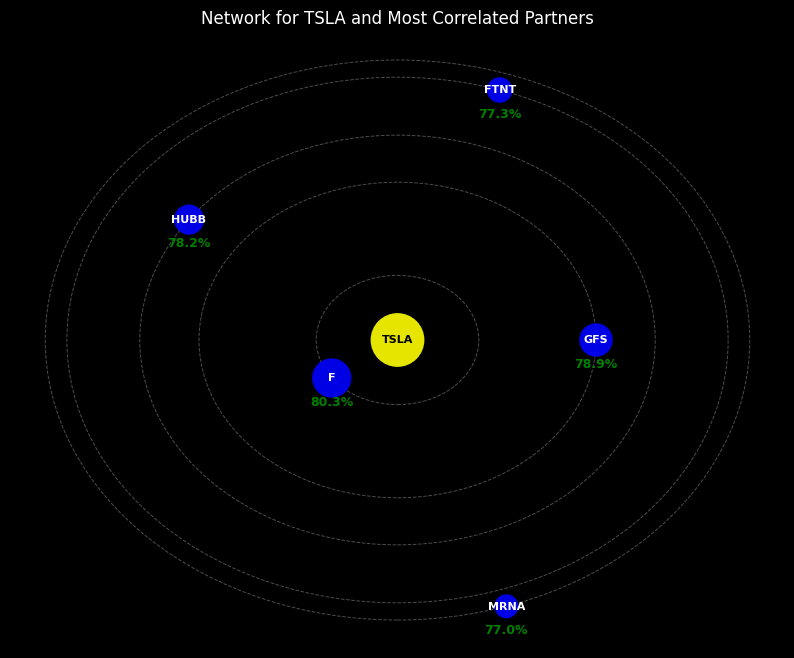

In [28]:
# Example usage:
plot_ticker_network_visual(processed_data, 'TSLA') # Replace 'AAPL' with the ticker you want to visualize